In [1]:
!pip install transformers opendatasets pandas seaborn scikit-learn --quiet
!pip install torch --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 51.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires torch<2.7,>=1.10, which is not installed.
fastai 2.7.19 requires torchvision>=0.11, which is not installed.
sentence-transformers 4.1.0 requires torch>=1.11.0, which is not installed.
peft 0.15.2 requires torch>=1.13.0, which is not installed.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import transformers
from transformers import ElectraTokenizerFast, ElectraForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from sklearn.utils.class_weight import compute_class_weight
import opendatasets as od

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
od.download("https://www.kaggle.com/datasets/kashishparmar02/social-media-sentiments-analysis-dataset")
file_path = '/content/social-media-sentiments-analysis-dataset/sentimentdataset.csv'
df = pd.read_csv(file_path)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: julfiqureantor
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kashishparmar02/social-media-sentiments-analysis-dataset


100%|██████████| 50.9k/50.9k [00:00<00:00, 93.3MB/s]

In [4]:
df['Sentiment_clean'] = df['Sentiment'].str.lower().str.strip()

In [5]:
positive = ['positive', 'joy', 'love', 'happy', 'hope', 'grateful', 'confidence', 'freedom', 'inspired']
negative = ['negative', 'anger', 'fear', 'sadness', 'hate', 'depression', 'disappointment', 'grief']

In [6]:
def map_sentiment(s):
    s = s.lower().strip()
    if s in positive:
        return 1
    elif s in negative:
        return 0
    else:
        return -1

In [7]:
df['label'] = df['Sentiment_clean'].apply(map_sentiment)
df = df[df['label'] != -1]  # Drop unmapped
print(df['label'].value_counts())

label
1    122
0     27
Name: count, dtype: int64


In [8]:
train_text, temp_text, train_labels, temp_labels = train_test_split(
    df['Text'], df['label'], random_state=2018, test_size=0.3, stratify=df['label'])

val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text, temp_labels, random_state=2018, test_size=0.5, stratify=temp_labels)

In [9]:
tokenizer = ElectraTokenizerFast.from_pretrained('google/electra-base-discriminator')
max_len = 64
tokens_train = tokenizer.batch_encode_plus(train_text.tolist(), max_length=max_len, padding=True, truncation=True)
tokens_val = tokenizer.batch_encode_plus(val_text.tolist(), max_length=max_len, padding=True, truncation=True)
tokens_test = tokenizer.batch_encode_plus(test_text.tolist(), max_length=max_len, padding=True, truncation=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

In [10]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [11]:
batch_size = 16
train_data = TensorDataset(train_seq, train_mask, train_y)
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=batch_size)

In [12]:
model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator')
model = model.to(device)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels.values)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
cross_entropy = nn.CrossEntropyLoss(weight=weights)
optimizer = AdamW(model.parameters(), lr=1e-5)

In [14]:
def train():
    model.train()
    total_loss, total_preds, total_labels = 0, [], []

    for batch in train_dataloader:
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        model.zero_grad()
        outputs = model(sent_id, attention_mask=mask)
        logits = outputs.logits
        loss = cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        total_preds.extend(preds)
        total_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(train_dataloader)
    accuracy = accuracy_score(total_labels, total_preds)
    return avg_loss, accuracy

In [15]:
def evaluate():
    model.eval()
    total_preds, total_labels = [], []

    with torch.no_grad():
        for batch in val_dataloader:
            batch = [t.to(device) for t in batch]
            sent_id, mask, labels = batch
            outputs = model(sent_id, attention_mask=mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            total_preds.extend(preds.cpu().numpy())
            total_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(total_labels, total_preds)
    return val_accuracy

In [16]:
epochs = 5
training_loss_list = []
validation_accuracy_list = []
best_val_accuracy = 0.0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_loss, _ = train()
    val_acc = evaluate()

    training_loss_list.append(train_loss)
    validation_accuracy_list.append(val_acc)
    print(f"Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), 'best_electra_model.pt')


Epoch 1/5
Train Loss: 0.6943 | Val Acc: 0.7727

Epoch 2/5
Train Loss: 0.6594 | Val Acc: 0.8182

Epoch 3/5
Train Loss: 0.6248 | Val Acc: 0.9091

Epoch 4/5
Train Loss: 0.5841 | Val Acc: 0.9545

Epoch 5/5
Train Loss: 0.5229 | Val Acc: 1.0000


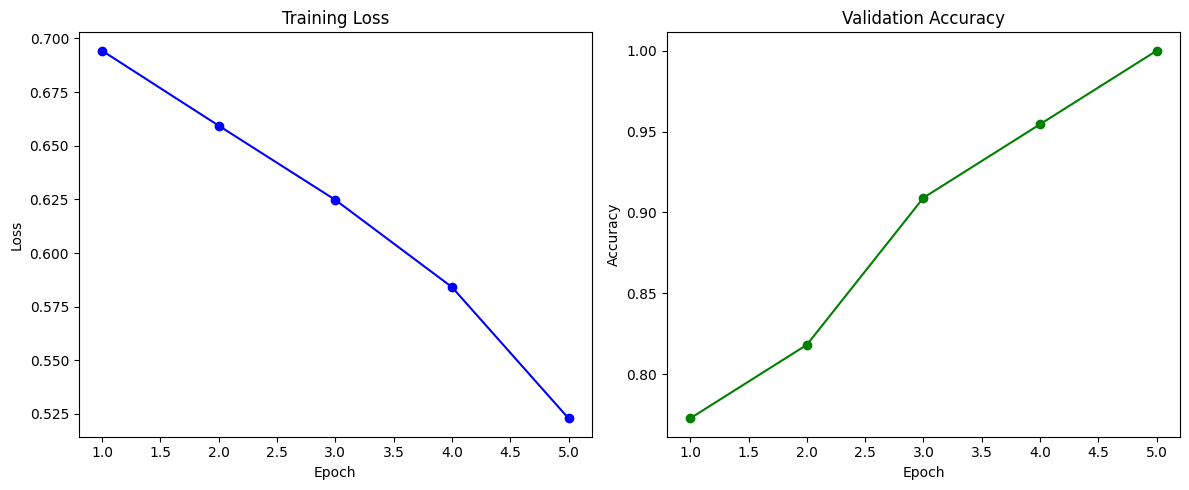

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), training_loss_list, 'b-o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), validation_accuracy_list, 'g-o')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [18]:
model.load_state_dict(torch.load('best_electra_model.pt'))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for batch in val_dataloader:
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        outputs = model(sent_id, attention_mask=mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


Best Validation Accuracy: 1.0000

Classification Report:

              precision    recall  f1-score   support

    Negative     1.0000    1.0000    1.0000         4
    Positive     1.0000    1.0000    1.0000        18

    accuracy                         1.0000        22
   macro avg     1.0000    1.0000    1.0000        22
weighted avg     1.0000    1.0000    1.0000        22



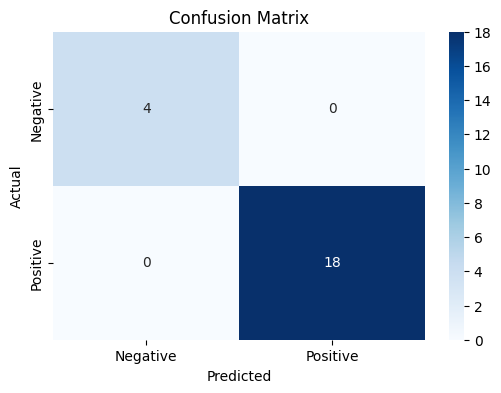

In [19]:
print(f"\nBest Validation Accuracy: {best_val_accuracy:.4f}\n")
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive'], digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()